# Flows conditioned with deep sets

In [1]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from flax import linen as nn
import numpy as np
import optax
from neural_flow import Flow
from neural_flow.bijectors import rolling_spline_coupling, Bijector
from typing import Callable
from matplotlib import pyplot as plt

# We generate some toy data, 1000 sets each with a size drawn from
# an exponential distribution. The maximum size is fixed to 400.
# Each set has elements which are vectors of size two.
rng = np.random.default_rng(1)


def generate(rng, size):
    n = rng.exponential(size=size)
    n *= 400 / np.max(n)
    n += 1  # ensure there are no empty sets
    n = n.astype(int)

    # The mapping to learn is a non-linear function of the inputs. One can also
    # replace np.mean with np.max or np.sum.
    def true_mapping(x):
        return len(x) ** 0.5

    X = [np.array(rng.normal(size=(ni, 2))) for ni in n]
    ym = [true_mapping(x) for x in X]
    y = rng.normal(ym, 1, size=(2, len(ym))).T

    return X, ym, y


def preprocess(X, y, padded_X_size):
    """
    Concatenates the input sets and pads inputs and outputs to fixed sizes.

    Returns padded arrays, the summation matrix, and a mask to undo the padding.
    """
    n = [len(x) for x in X]
    assert padded_X_size >= np.sum(n)
    X = np.concatenate(X)
    X = np.concatenate([X, np.zeros((padded_X_size - len(X),) + X.shape[1:])])
    indices = np.empty((np.sum(n), 2), dtype=int)
    a = 0
    for j, b in enumerate(np.cumsum(n)):
        indices[a:b, 0] = j
        indices[a:b, 1] = np.arange(a, b)
        a = b
    sum_matrix = sparse.BCOO(
        (np.ones(len(indices), dtype=np.int8), indices),
        shape=(len(y), padded_X_size)
    )
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y, sum_matrix


X_train, ym_train, y_train = generate(rng, 1000)
ym_train = jnp.array(ym_train)
X_train, y_train, sum_train = preprocess(X_train, y_train, 50_000)

X_test, ym_test, y_test = generate(rng, 100)
ym_test = jnp.array(ym_test)
X_test, y_test, sum_test = preprocess(X_test, y_test, sum(len(x) for x in X_test))

epoch 0 loss[train] =       3.27 loss[test] =      13.18
epoch 100 loss[train] =       0.08 loss[test] =       0.23
epoch 200 loss[train] =       0.02 loss[test] =       0.07
epoch 300 loss[train] =       0.03 loss[test] =       0.05
epoch 400 loss[train] =       0.00 loss[test] =       0.02
epoch 500 loss[train] =       0.00 loss[test] =       0.02
epoch 600 loss[train] =       0.00 loss[test] =       0.01
epoch 700 loss[train] =       0.01 loss[test] =       0.02
epoch 800 loss[train] =       0.01 loss[test] =       0.02
epoch 900 loss[train] =       0.01 loss[test] =       0.01


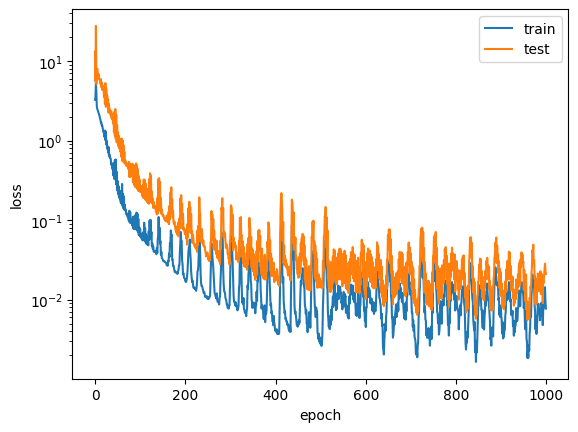

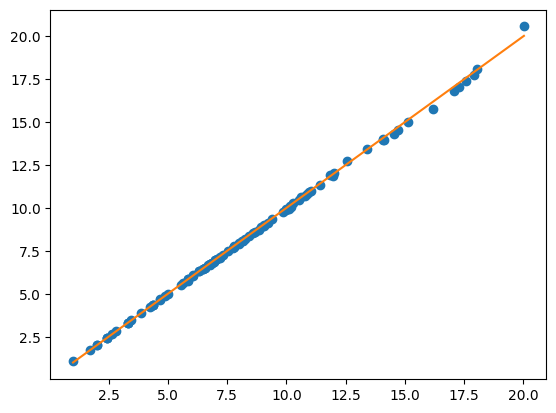

In [2]:
class NNBlock(nn.Module):
    out_dim: int
    depth: int
    width: int
    act: Callable = nn.swish

    @nn.compact
    def __call__(self, x):
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = self.act(x)
        return nn.Dense(self.out_dim)(x)


class Phi(nn.Module):
    @nn.compact
    def __call__(self, x, sum_matrix, train: bool = False):
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = NNBlock(8, 3, 128)(x)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        x = sum_matrix @ x
        return x


class DeepSet(nn.Module):
    @nn.compact
    def __call__(self, x, sum_matrix, train: bool = False):
        x = Phi()(x, sum_matrix, train)
        x = NNBlock(1, 3, 128)(x)
        return x.reshape(-1)


deep_set = DeepSet()
root_key = jax.random.PRNGKey(0)
init_key, dropout_key = jax.random.split(root_key)

variables = deep_set.init(init_key, X_train, sum_train)
params = variables["params"]
batch_stats = variables["batch_stats"]

opt = optax.nadamw(learning_rate=1e-3)
opt_state = opt.init(params)


@jax.jit
def loss_fn(params, batch_stats, x, sum_matrix, y, dropout_key):
    yp, updates = deep_set.apply(
        {"params": params, "batch_stats": batch_stats},
        x,
        sum_matrix,
        train=True,
        mutable=["batch_stats"],
        rngs={"dropout": dropout_key},
    )
    return jnp.mean(optax.l2_loss(yp, y)), updates


@jax.jit
def metric_fn(variables, x, sum_matrix, y):
    yp = deep_set.apply(variables, x, sum_matrix)
    return jnp.mean(optax.l2_loss(yp, y))


@jax.jit
def step(params, batch_stats, opt_state, x, sum_matrix, y, dropout_key):
    grad, updates = jax.grad(loss_fn, has_aux=True)(
        params, batch_stats, x, sum_matrix, y, dropout_key
    )
    batch_stats = updates["batch_stats"]
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, batch_stats, opt_state


best_epoch = 0
best_variables = variables
loss_train = []
loss_test = []
patience = 100
for epoch in range(1_000):
    dropout_train_key = jax.random.fold_in(dropout_key, data=epoch)
    params, batch_stats, opt_state = step(
        params, batch_stats, opt_state, X_train, sum_train, ym_train, dropout_train_key
    )
    variables = {"params": params, "batch_stats": batch_stats}
    loss_train.append(metric_fn(variables, X_train, sum_train, ym_train))
    loss_test.append(metric_fn(variables, X_test, sum_test, ym_test))
    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_variables = variables

    stop = np.isnan(loss_train[-1])
    if epoch >= 2 * patience and epoch % patience == 0:
        stop |= not np.min(loss_test[-patience:]) < np.min(
            loss_test[-2 * patience : -patience]
        )

    if epoch % 100 == 0:
        print(
            f"epoch {epoch} loss[train] = {loss_train[-1]:10.2f} "
            f"loss[test] = {loss_test[-1]:10.2f}"
        )

    if stop:
        break


plt.figure()
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.semilogy()

plt.figure()
ym_pred = deep_set.apply(best_variables, X_test, sum_test)
plt.scatter(ym_test, ym_pred)
diag = [np.min(ym_test), np.max(ym_test)]
plt.plot(diag, diag, color="C1");

epoch 0 8.43 9.38
epoch 100 4.51 4.16
epoch 200 3.28 3.27
epoch 300 3.08 3.16
epoch 400 2.82 2.93
epoch 500 2.70 2.89
epoch 600 3.01 3.21
epoch 700 2.68 2.94
epoch 800 2.70 3.41
epoch 900 2.69 3.02
best loss[test] = 2.76


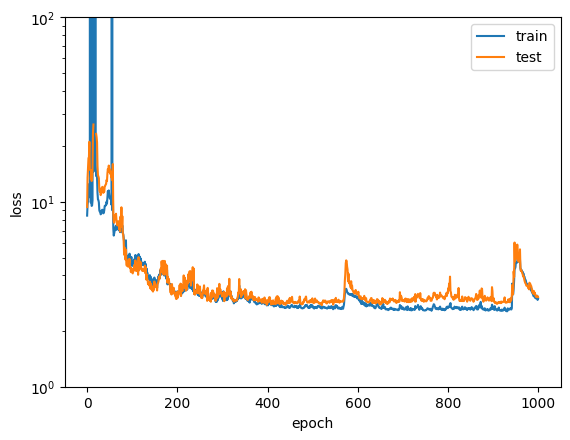

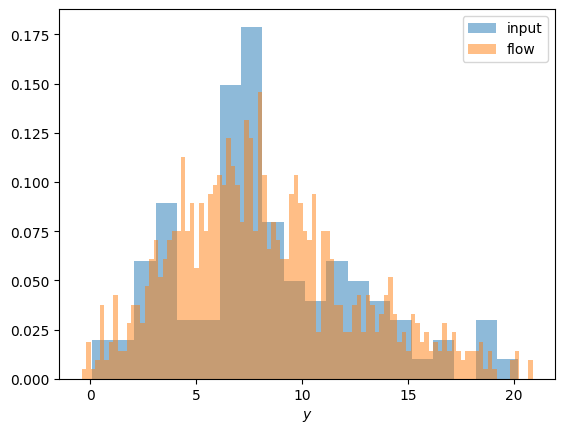

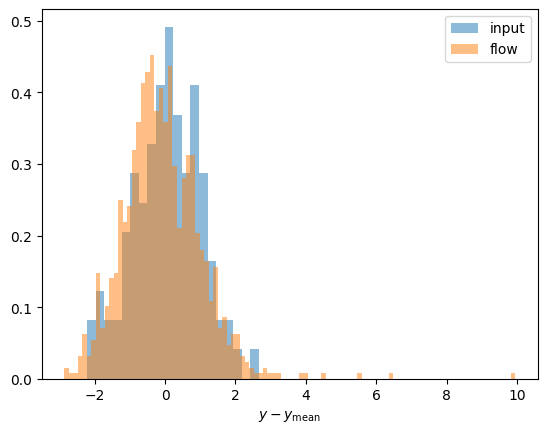

In [3]:
class DeepSetFlow(nn.Module):
    c_dim: int
    bijector: Bijector = rolling_spline_coupling(2)

    def setup(self):
        self.phi = Phi()
        self.flow = Flow(self.bijector)

    @nn.compact
    def __call__(self, x, sum_matrix, y, train: bool = False):
        c = self.phi(x, sum_matrix, train)
        log_prob = self.flow(y, c, train=train)
        return log_prob

    def sample(self, x, sum_matrix, sizes, seed):
        c = self.phi(x, sum_matrix)
        c = jnp.repeat(c, sizes, axis=0)
        return self.flow.sample(c, seed=seed)


deep_set_flow = DeepSetFlow(1, rolling_spline_coupling(2, layers=(128,) * 6))
variables = deep_set_flow.init(init_key, X_train, sum_train, y_train)

@jax.jit
def loss_fn_2(params, batch_stats, x, sum_matrix, y, dropout_key):
    log_prob, updates = deep_set_flow.apply(
        {"params": params, "batch_stats": batch_stats},
        x,
        sum_matrix,
        y,
        train=True,
        mutable=["batch_stats"],
        rngs={"dropout": dropout_key},
    )
    return -np.mean(log_prob), updates


@jax.jit
def metric_fn_2(variables, x, sum_matrix, y):
    log_prob = deep_set_flow.apply(variables, x, sum_matrix, y)
    return -np.mean(log_prob)


params = variables["params"]
batch_stats = variables["batch_stats"]
opt = optax.nadamw(learning_rate=1e-3)
opt_state = opt.init(params)


@jax.jit
def step(params, batch_stats, opt_state, x, sum_matrix, y, dropout_key):
    grad, updates = jax.grad(loss_fn_2, has_aux=True)(
        params, batch_stats, x, sum_matrix, y, dropout_key
    )
    batch_stats = updates["batch_stats"]
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, batch_stats


best_epoch = 0
best_variables = variables
loss_train = []
loss_test = []
for epoch in range(1000):
    dropout_train_key = jax.random.fold_in(dropout_key, epoch)
    params, opt_state, batch_stats = step(
        params, batch_stats, opt_state, X_train, sum_train, y_train, dropout_train_key
    )
    variables = {"params": params, "batch_stats": batch_stats}
    loss_train.append(metric_fn_2(variables, X_train, sum_train, y_train))
    loss_test.append(metric_fn_2(variables, X_test, sum_test, y_test))

    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_variables = variables

    if epoch % 100 == 0:
        print(f"epoch {epoch} {loss_train[-1]:.2f} {loss_test[-1]:.2f}")

print(f"best loss[test] = {loss_test[best_epoch]:.2f}")


plt.figure()
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1, 1e2)
plt.semilogy()

size = 10

y_pred = deep_set_flow.apply(
    best_variables, X_test, sum_test, size, seed=0, method="sample"
)

plt.figure()
plt.hist(y_test[:, 0], bins=20, density=True, alpha=0.5, label="input")
plt.hist(y_pred[:, 0], bins=100, density=True, alpha=0.5, label="flow")
plt.xlabel("$y$")
plt.legend()

plt.figure()
plt.hist(y_test[:, 0] - ym_test, bins=20, density=True, alpha=0.5, label="input")
plt.hist(
    y_pred[:, 0] - jnp.repeat(ym_test, size),
    bins=100,
    density=True,
    alpha=0.5,
    label="flow",
)
plt.xlabel(r"$y - y_\mathrm{mean}$")
plt.legend();

In [4]:
jax.tree_map(lambda x:x.shape, best_variables["params"])

{'bijector': {'bijectors_1': {'BatchNorm_0': {'bias': (9,), 'scale': (9,)},
   'Dense_0': {'bias': (128,), 'kernel': (9, 128)},
   'Dense_1': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_2': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_3': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_4': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_5': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_6': {'bias': (47,), 'kernel': (128, 47)}},
  'bijectors_3': {'BatchNorm_0': {'bias': (9,), 'scale': (9,)},
   'Dense_0': {'bias': (128,), 'kernel': (9, 128)},
   'Dense_1': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_2': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_3': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_4': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_5': {'bias': (128,), 'kernel': (128, 128)},
   'Dense_6': {'bias': (47,), 'kernel': (128, 47)}}},
 'phi': {'BatchNorm_0': {'bias': (2,), 'scale': (2,)},
  'NNBlock_0': {'Dense_0': {'bias': (128,), 'kernel': 

bijector bijectors_1 Dense_0 kernel
bijector bijectors_1 Dense_1 kernel
bijector bijectors_1 Dense_2 kernel
bijector bijectors_1 Dense_3 kernel
bijector bijectors_1 Dense_4 kernel
bijector bijectors_1 Dense_5 kernel
bijector bijectors_1 Dense_6 kernel
bijector bijectors_3 Dense_0 kernel
bijector bijectors_3 Dense_1 kernel
bijector bijectors_3 Dense_2 kernel
bijector bijectors_3 Dense_3 kernel
bijector bijectors_3 Dense_4 kernel
bijector bijectors_3 Dense_5 kernel
bijector bijectors_3 Dense_6 kernel
phi NNBlock_0 Dense_0 kernel
phi NNBlock_0 Dense_1 kernel
phi NNBlock_0 Dense_2 kernel
phi NNBlock_0 Dense_3 kernel


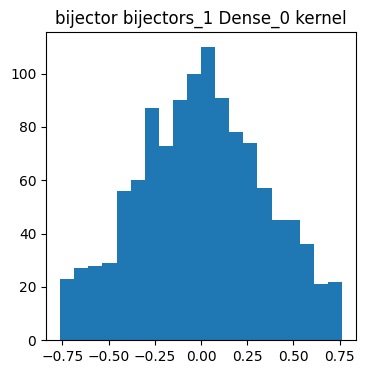

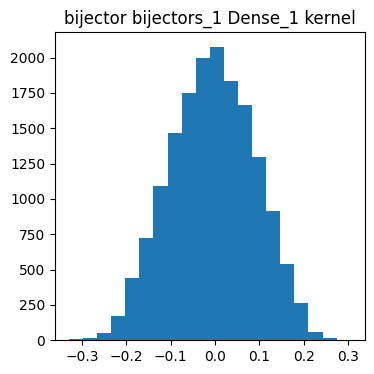

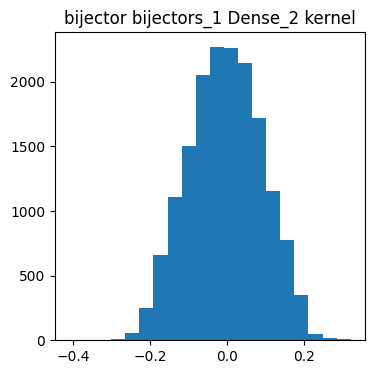

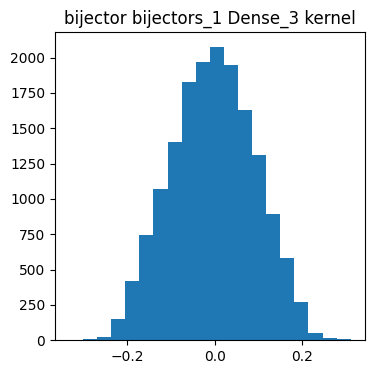

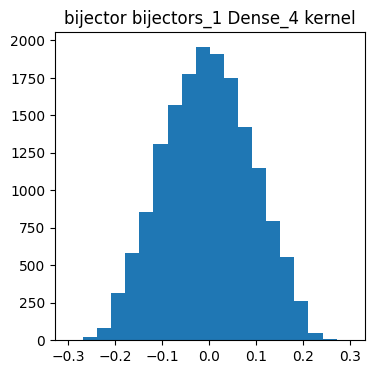

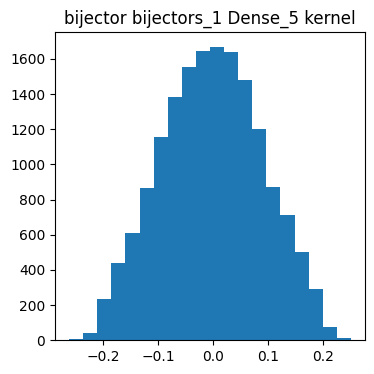

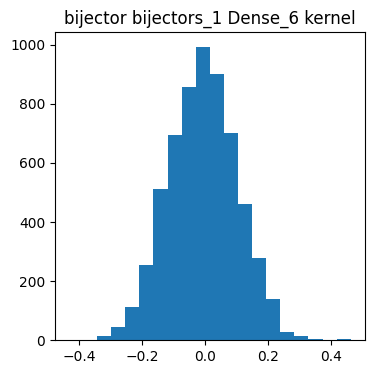

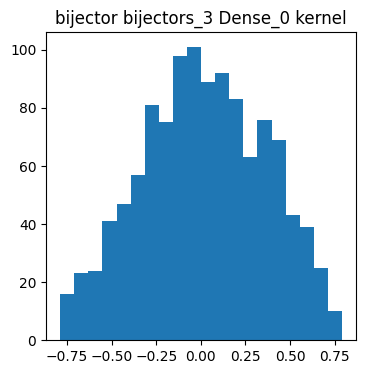

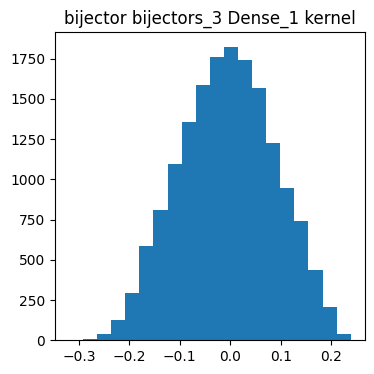

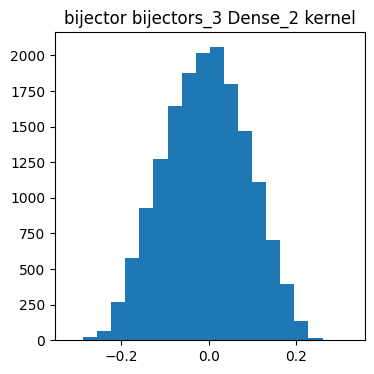

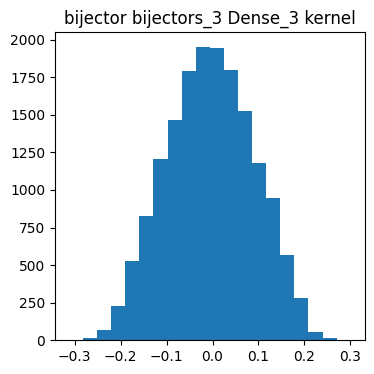

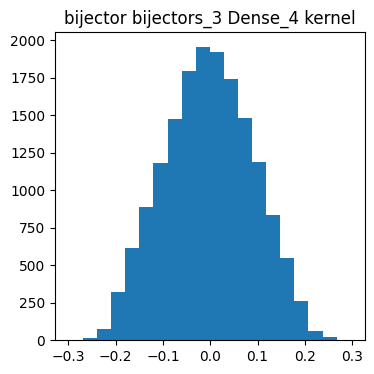

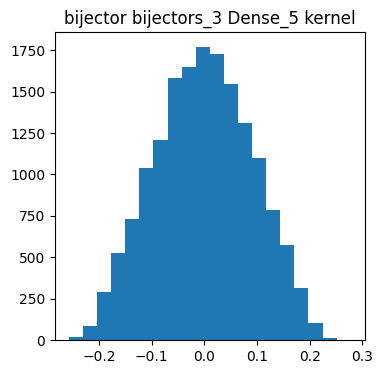

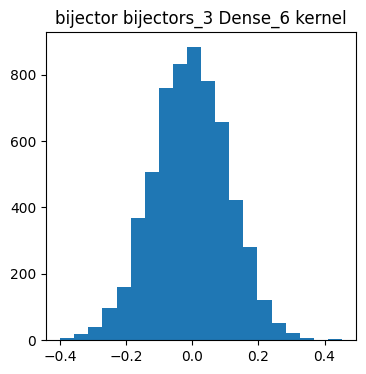

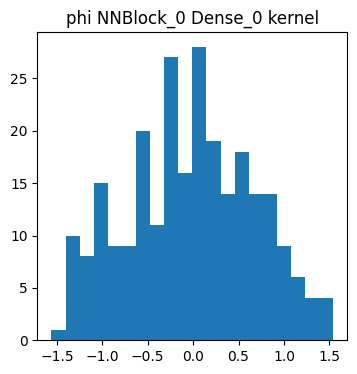

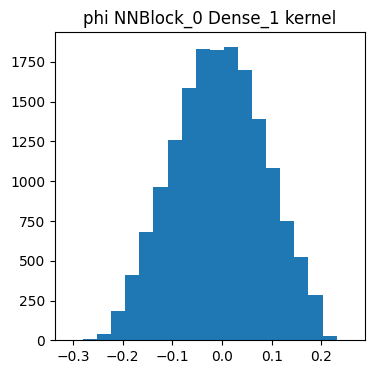

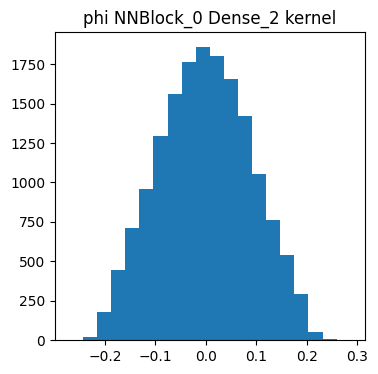

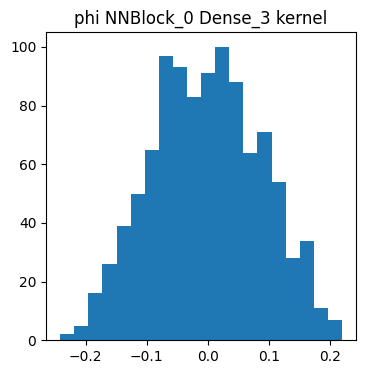

In [5]:
def visitor(x, parent=()):
    if hasattr(x, "items"):
        for k, v in x.items():
            visitor(v, parent + (k,))
        return
    label = " ".join(parent)
    if "BatchNorm" in label or "bias" in label:
        return
    print(label)
    plt.figure(figsize=(4, 4))
    plt.title(label)
    plt.hist(x.flatten(), bins=20)

visitor(best_variables["params"])